In [1]:
import numpy as np
import pandas as pd
import mne
import glob
import os
from matplotlib import pyplot as plt
from utils.freq_calculator import do_bandpass, prepare_fft
import copy

from utils.lag_calculator import (
    epoch_data,
    remove_outliers,
    replace_outliers,
    calculate_epochs_lag,
    prepare_prodigy_data,
    prepare_idun_data,
    polynomial_regression_on_lag,
    cut_throughout_data,
    cut_at_end,
    apply_shift_to_data,
    adjust_data_by_mean_lag,
    equalize_data_length,
    clean_data_from_spikes,
    cut_throughout_data_arr
)
import config

### Upload all data

In [13]:
folder = "01_Pre_study"
subject = "S001"
night = "night1"
edf_file_path = glob.glob(os.path.join(folder, subject, night, "*.edf"))[0]
csv_file_path = glob.glob(os.path.join(folder, subject, night, "*eeg.csv"))[0]
prodigy_raw_data = mne.io.read_raw_edf(edf_file_path, preload=True)
# upload csv file using numpy
idun_raw_data = np.genfromtxt(csv_file_path, delimiter=",", skip_header=1)
# print the paths
print(edf_file_path)
print(csv_file_path)

Extracting EDF parameters from /Users/waddaben/Desktop/code/idn-sync-data/01_Pre_study/S001/night1/16696 - Night 1 - 555571 - output-scoring.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3088799  =      0.000 ... 25739.992 secs...
01_Pre_study/S001/night1/16696 - Night 1 - 555571 - output-scoring.edf
01_Pre_study/S001/night1/202307172227_eeg.csv


### Unpack prodigy data

In [14]:
prodigy_base_data_df, prodigy_filtered_data_rs, resampled_times = prepare_prodigy_data(
    prodigy_raw_data, config
)
pr_freqs_rs, pr_fft_rs = prepare_fft(
    prodigy_filtered_data_rs,
    config.FILTER_RANGE[0] - 5,
    config.FILTER_RANGE[1] + 5,
    config.BASE_SAMPLE_RATE,
)
# print columns of the dataframe
print(prodigy_base_data_df.columns)

Index(['AUDIO', 'CHIN', 'LEFT_EEG', 'LEFT_EYE', 'MASTOID', 'POSITION',
       'RIGHT_EEG', 'RIGHT_EYE'],
      dtype='object')


(-200.0, 200.0)

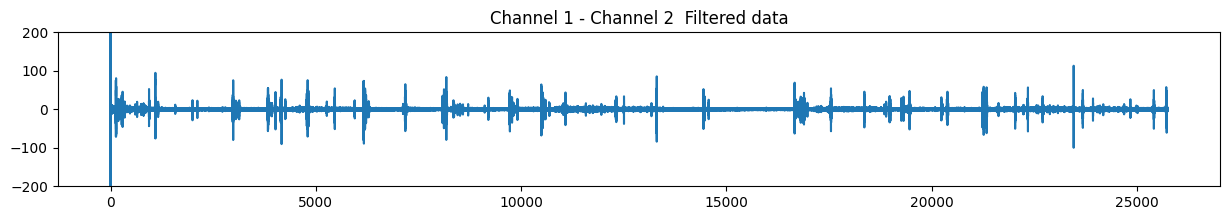

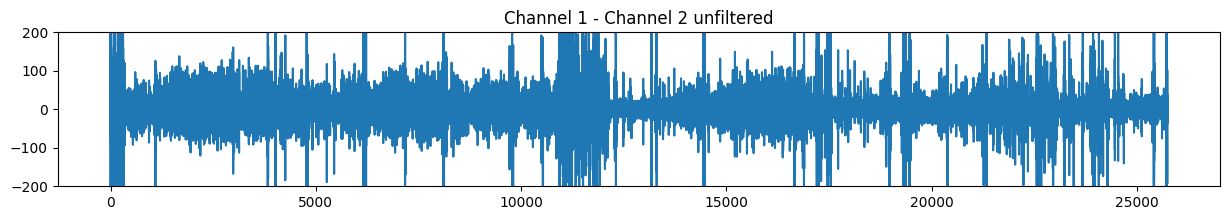

In [15]:
plt.figure(figsize=(15, 2))
plt.plot(resampled_times, prodigy_filtered_data_rs)
plt.title("Channel 1 - Channel 2  Filtered data")
plt.ylim(-200, 200)
# Plot the fft of the data
plt.figure(figsize=(15, 2))
plt.plot(
    resampled_times,
    (prodigy_base_data_df[config.CHANNEL_1] - prodigy_base_data_df[config.CHANNEL_2])
    * 1000000,
)
plt.title("Channel 1 - Channel 2 unfiltered")
plt.ylim(-200, 200)

### Unpack IDUN data

In [16]:
idun_base_data, idun_filtered_data, idun_time_stamps = prepare_idun_data(
    idun_raw_data, config
)

Text(0.5, 1.0, 'IDUN Highpassed data')

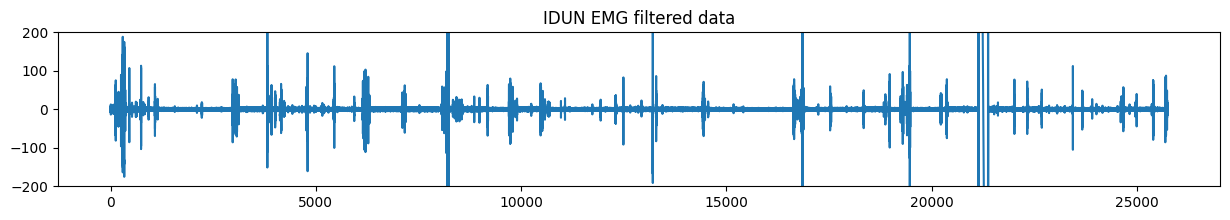

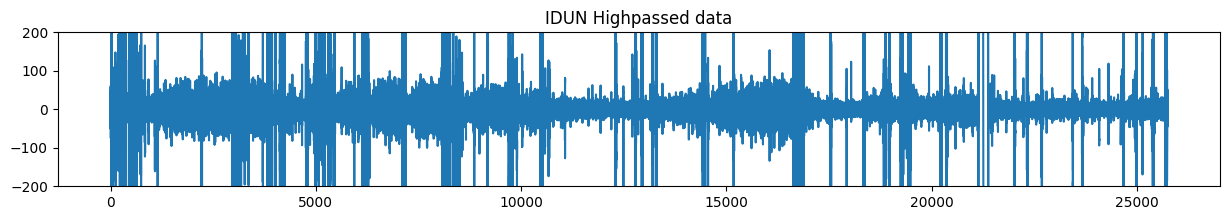

In [17]:
plt.figure(figsize=(15, 2))
plt.plot(idun_time_stamps, idun_filtered_data)
plt.ylim(-200, 200)
plt.title("IDUN EMG filtered data")

plt.figure(figsize=(15, 2))
plt.plot(idun_time_stamps, idun_base_data)
plt.ylim(-200, 200)
plt.title("IDUN Highpassed data")

### Make data same length

In [18]:
# To use the function
(
    prodigy_clipped_data,
    idun_clipped_data,
    idun_base_clipped_data,
    prodigy_base_clipped_df,
    same_times,
) = equalize_data_length(
    prodigy_filtered_data_rs,
    idun_filtered_data,
    idun_base_data,
    prodigy_base_data_df,
    config,
)

Comparison data is longer with 246.56 seconds, cutting from end of Prodigy data


### DO MANUAL SHIFTING 

### ------------------------------------------------------------------------------------------------

In [22]:
SHIFT_SECONDS = -100 #TODO: Do initial shift automatically using time stamps of the data
# save as txt file the shift amount in seconds
np.savetxt(
    os.path.join(folder, subject, night, "shift_seconds.txt"),
    [SHIFT_SECONDS],
    delimiter=",",
)

### ------------------------------------------------------------------------------------------------

In [23]:
SHIFT = SHIFT_SECONDS * config.BASE_SAMPLE_RATE
(
    idun_pre_cut_data,
    idun_base_pre_cut_data,
    prodigy_pre_cut_data,
    prodigy_base_pre_cut_df,
) = apply_shift_to_data(
    SHIFT,
    idun_clipped_data,
    idun_base_clipped_data,
    prodigy_clipped_data,
    prodigy_base_clipped_df,
)

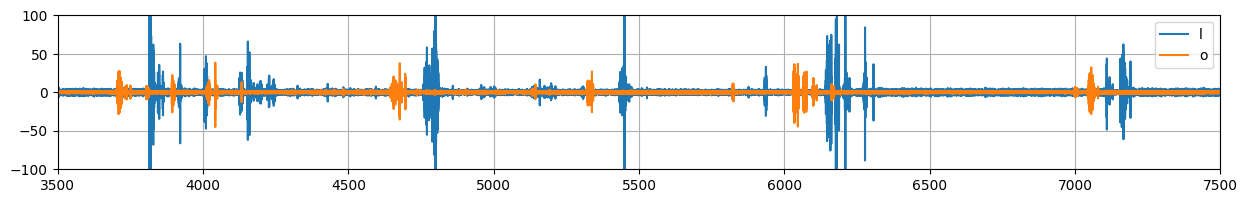

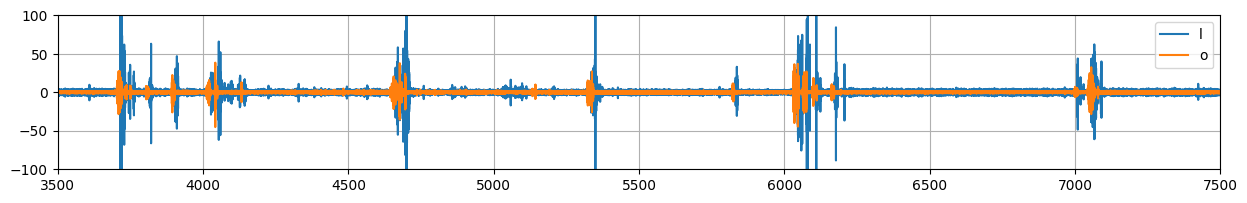

In [24]:
x_start = 3500
range_viz = 4000

plt.figure(figsize=(15, 2))
plt.plot(same_times, idun_clipped_data, label="idun")
plt.plot(same_times, 0.5 * prodigy_clipped_data, label="prodigy")
plt.xlim(x_start, x_start + range_viz)
plt.legend("lower right")
plt.ylim(-100, 100)
plt.grid()


new_times = np.linspace(
    0, len(idun_pre_cut_data) / config.BASE_SAMPLE_RATE, len(idun_pre_cut_data)
)
plt.figure(figsize=(15, 2))
plt.plot(new_times, idun_pre_cut_data, label="idun")
plt.plot(new_times, 0.5 * prodigy_pre_cut_data, label="prodigy")
plt.xlim(x_start, x_start + range_viz)
plt.legend("lower right")
plt.ylim(-100, 100)
plt.grid()

### Calculate lag

In [25]:
# extract only the first 1000 seconds
prodigy_clipped_temp_data = copy.deepcopy(prodigy_pre_cut_data)
idun_clipped_temp_data = copy.deepcopy(idun_pre_cut_data)

search_size = config.FIRST_LAG_EPOCH_SIZE

prodigy_epochs = epoch_data(prodigy_clipped_temp_data, search_size)
idun_epochs = epoch_data(idun_clipped_temp_data, search_size)
# extract only the f

In [26]:
correlation_arr, max_corr_arr, lag_arr = calculate_epochs_lag(
    prodigy_epochs, idun_epochs
)
lag_arr_copy = lag_arr[1:].copy()

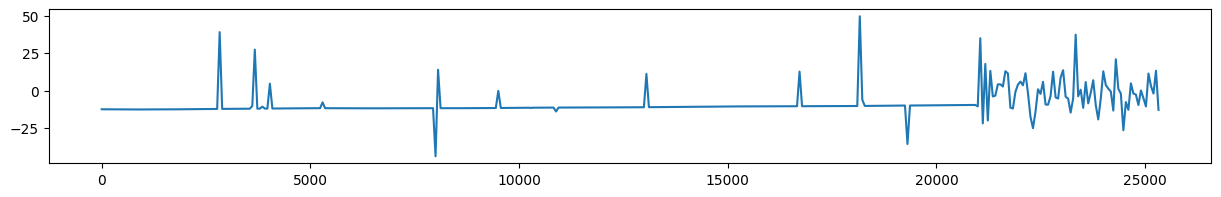

In [27]:
plt.figure(figsize=(15, 2))
# create a time array based on config.FIRST_LAG_EPOCH_SIZE and length of lag_arr_copy
plot_time_arr = np.linspace(
    0, len(lag_arr_copy) * config.FIRST_LAG_EPOCH_SIZE, len(lag_arr_copy)
)
# convert  to seconds
plot_time_arr = plot_time_arr / config.BASE_SAMPLE_RATE
plt.plot(plot_time_arr, np.array(lag_arr_copy) / 250)

### Cut based on first analysis

In [28]:
lag_arr = np.array(lag_arr)
lag_initial = lag_arr[:20]
lag_initial = remove_outliers(lag_initial)
lag_mean = lag_initial[0]

# cut the lag_mean data from the start of idun_clipped_data if it is positive or from the start of  if negative
if lag_mean < 0:
    idun_cut_data = idun_pre_cut_data[-lag_mean:]
    idun_base_cut_data = idun_base_pre_cut_data[-lag_mean:]
    prodigy_cut_data = prodigy_pre_cut_data[:-(-lag_mean)]
    prodigy_base_cut_df = prodigy_base_pre_cut_df[:-(-lag_mean)].reset_index(drop=True)
else:
    idun_cut_data = idun_pre_cut_data[:-(lag_mean)]
    idun_base_cut_data = idun_base_pre_cut_data[:-(lag_mean)]
    prodigy_cut_data = prodigy_pre_cut_data[lag_mean:]
    prodigy_base_cut_df = prodigy_base_pre_cut_df[lag_mean:].reset_index(drop=True)

lag_mean:  -12.54


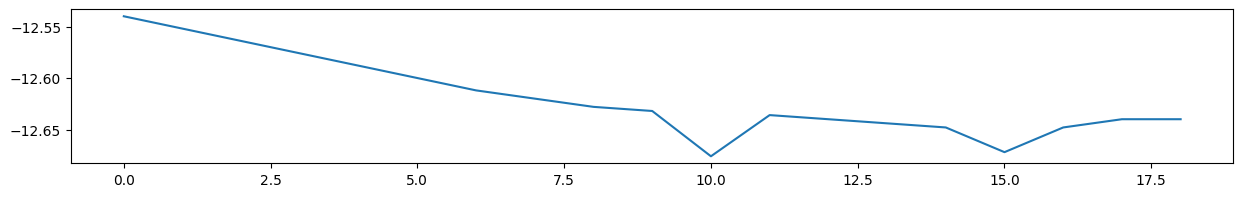

In [29]:
# plot the data
plt.figure(figsize=(15, 2))
plt.plot(lag_initial / 250, label="idun")
print("lag_mean: ", lag_mean / 250)

/Users/waddaben/.local/share/virtualenvs/idn-sync-data-pWEap7XJ/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/waddaben/.local/share/virtualenvs/idn-sync-data-pWEap7XJ/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


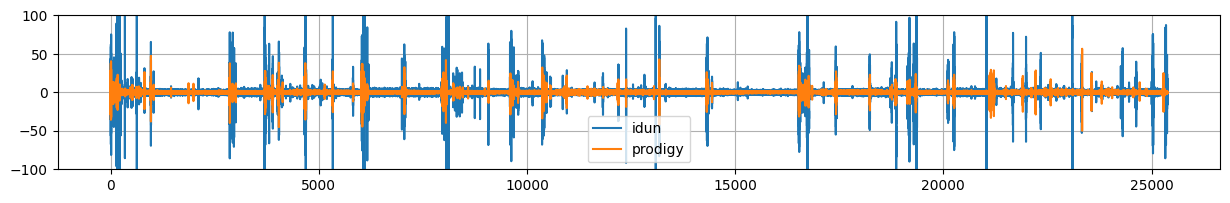

In [30]:
# plot the data
plt.figure(figsize=(15, 2))
time_seconds = np.arange(len(idun_cut_data)) / config.BASE_SAMPLE_RATE
plt.plot(time_seconds, idun_cut_data, label="idun")
plt.plot(time_seconds, 0.5 * prodigy_cut_data, label="prodigy")
plt.legend()
plt.ylim(-100, 100)
plt.grid()

### Do a more fine grained sync

In [31]:
cutted_prodigy_epochs = epoch_data(prodigy_cut_data, config.SECOND_LAG_EPOCH_SIZE)
cutted_idun_epochs = epoch_data(idun_cut_data, config.SECOND_LAG_EPOCH_SIZE)

In [32]:
fine_correlation_arr, fine_max_corr_arr, fine_lag_arr = calculate_epochs_lag(
    cutted_prodigy_epochs, cutted_idun_epochs
)

(-1.0, 5.0)

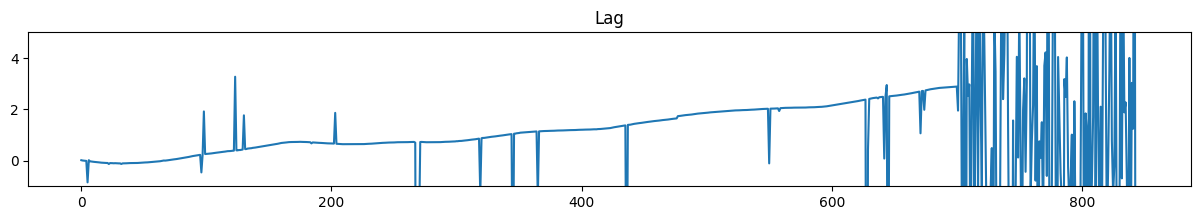

In [33]:
fine_lag_arr_copy = fine_lag_arr.copy()
plt.figure(figsize=(15, 2))
plt.plot(np.array(fine_lag_arr_copy) / 250)
plt.title("Lag")
plt.ylim(-1, 5)

### Do some cleaning on lag estimation

### ------------------------------------------------------------------------------------------------

In [34]:
DISCONTINUITY_THRESHOLD = 20
# save as txt file the correlation strictness
np.savetxt(
    os.path.join(folder, subject, night, "discontinuity_threshold.txt"),
    [DISCONTINUITY_THRESHOLD],
    delimiter=",",
)

### ------------------------------------------------------------------------------------------------

Text(0.5, 1.0, 'Lag')

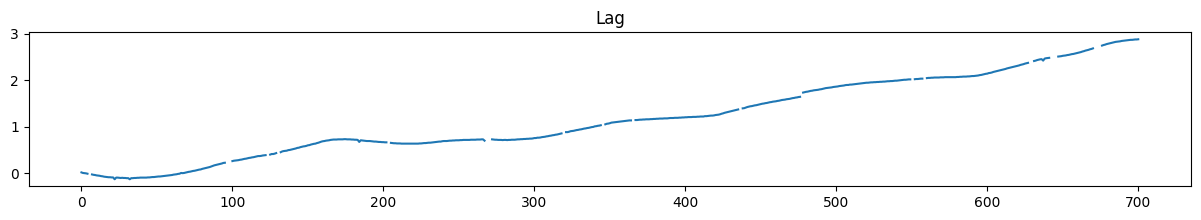

In [35]:

cleaned_fine_lag_arr = clean_data_from_spikes(fine_lag_arr, DISCONTINUITY_THRESHOLD)
plt.figure(figsize=(15, 2))
plt.plot(cleaned_fine_lag_arr / 250)
plt.title("Lag")

### Fit a curve to the data

### ------------------------------------------------------------------------------------------------

In [46]:
POLYNOMIAL_DEGREE = 3
# Save the polynomial degree to a txt file
np.savetxt(
    os.path.join(folder, subject, night, "polynomial_degree.txt"),
    [POLYNOMIAL_DEGREE],
    delimiter=",",
)

### ------------------------------------------------------------------------------------------------

In [47]:
linear_regression_lag = polynomial_regression_on_lag(
    cleaned_fine_lag_arr, POLYNOMIAL_DEGREE
)

In [69]:
linear_regression_lag[0]

-39.70772683243189

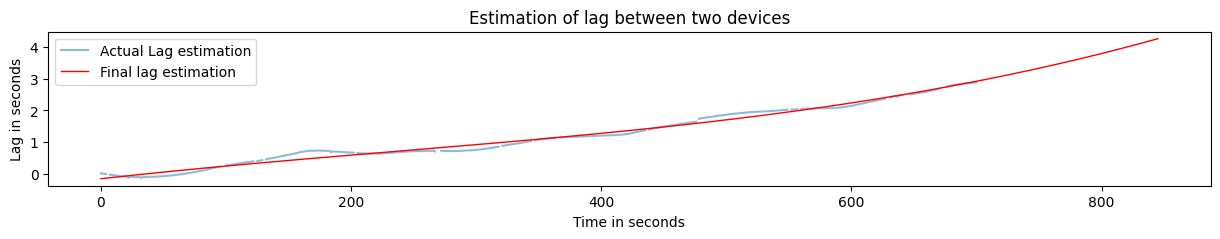

In [71]:
# Plotting the regression curve
plt.figure(figsize=(15, 2))
plt.plot(cleaned_fine_lag_arr / 250, label="Actual Lag estimation", alpha=0.5)
plt.plot(linear_regression_lag / 250, "r-", label="Final lag estimation", linewidth=1)
plt.title("Estimation of lag between two devices")
plt.xlabel("Time in seconds")
plt.ylabel("Lag in seconds")
plt.legend()
plt.savefig(
    os.path.join(folder, subject, night, "lag_estimation.png"),
    dpi=300,
    bbox_inches="tight",
)

### Create linear knots

In [49]:
x_axis_simulated = np.linspace(
    0, len(linear_regression_lag) - 1, len(linear_regression_lag)
)  # This will be 0 to 718
x_knots = np.linspace(
    0, len(linear_regression_lag) - 1, config.TOTAL_LINEAR_SEGMENTS + 1
)
y_knots = linear_regression_lag[
    (x_knots).astype(int)
]  # Directly get the y-values from y_pred

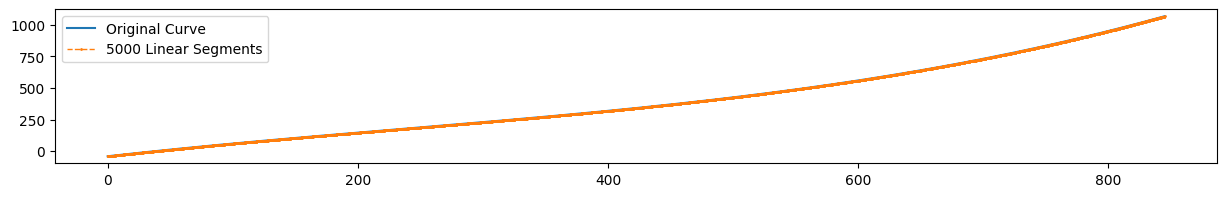

In [68]:
# Plot
plt.figure(figsize=(15, 2))
plt.plot(x_axis_simulated, linear_regression_lag, label="Original Curve")
plt.plot(
    x_knots,
    y_knots,
    label=f"{config.TOTAL_LINEAR_SEGMENTS} Linear Segments",
    linestyle="--",
    marker="o",
    linewidth=1,
    markersize=1,
)
plt.legend()
plt.show()

### Use the Linear lines to estimate the difference in sampling rates and apply

In [51]:
point_size = config.SECOND_LAG_EPOCH_SIZE
adjustment_epoch_size = int(len(prodigy_cut_data) / config.TOTAL_LINEAR_SEGMENTS)
lag_positions = np.arange(0, len(prodigy_cut_data), adjustment_epoch_size)
cumulative_lags = y_knots.astype(int)
lag_sizes = np.diff(cumulative_lags)

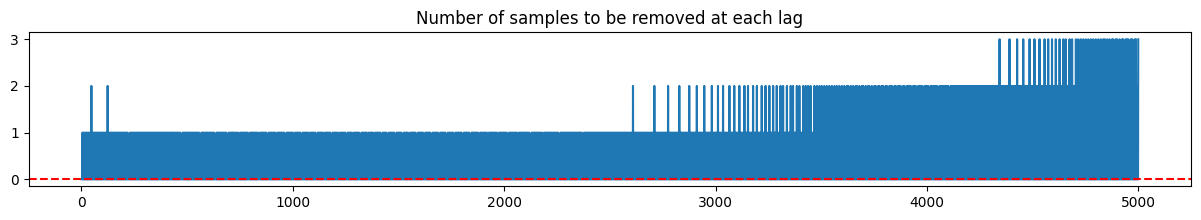

In [52]:
plt.figure(figsize=(15, 2))
plt.plot(lag_sizes)
plt.title("Number of samples to be removed at each lag")
plt.axhline(y=0, color="r", linestyle="--")

### Cut the data throughout and at the end

In [53]:
if np.sum(lag_sizes < 0) > np.sum(lag_sizes > 0):
    print("Pruning IDUN data")
    idun_data_pruned, idun_base_pruned = cut_throughout_data_arr(
        idun_cut_data, idun_base_cut_data, lag_positions, -cumulative_lags
    )
    prodigy_data_pruned = copy.deepcopy(prodigy_cut_data)
    prodigy_base_pruned_df = copy.deepcopy(prodigy_base_cut_df)
else:
    print("Pruning Prodigy data")
    prodigy_data_pruned, prodigy_base_pruned_df = cut_throughout_data(
    prodigy_cut_data, prodigy_base_cut_df, lag_positions, cumulative_lags
    )
    idun_data_pruned = copy.deepcopy(idun_cut_data)
    idun_base_pruned = copy.deepcopy(idun_base_cut_data)

(
    prodigy_data_pruned,
    prodigy_base_pruned_df,
    idun_data_pruned,
    idun_base_pruned,
) = cut_at_end(
    prodigy_data_pruned,
    prodigy_base_pruned_df,
    idun_data_pruned,
    idun_base_pruned,
)

Pruning Prodigy data


In [54]:
final_prodigy_epochs = epoch_data(
    prodigy_data_pruned, config.SECOND_LAG_EPOCH_SIZE
)
final_idun_epochs = epoch_data(idun_data_pruned, config.SECOND_LAG_EPOCH_SIZE)

In [55]:
final_correlation_arr, final_max_corr_arr, final_lag_arr = calculate_epochs_lag(
    final_prodigy_epochs, final_idun_epochs
)

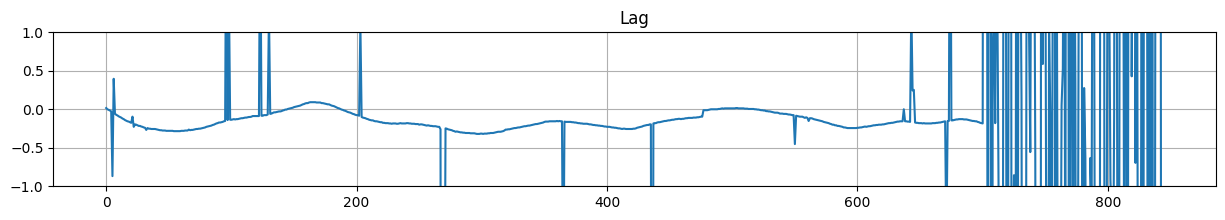

In [57]:
final_lag_arr_copy = final_lag_arr.copy()
plt.figure(figsize=(15, 2))
plt.plot(np.array(final_lag_arr) / 250)
plt.title("Lag")
plt.ylim(-1, 1)
plt.grid()

### Clean the lags

In [58]:
cleaned_final_lag_arr = replace_outliers(final_lag_arr_copy)
# rfind where the values are nan
nan_idx = np.argwhere(np.isnan(cleaned_final_lag_arr))
# remove the nan values
mean_final_lag = np.mean(np.delete(cleaned_final_lag_arr, nan_idx, axis=0))

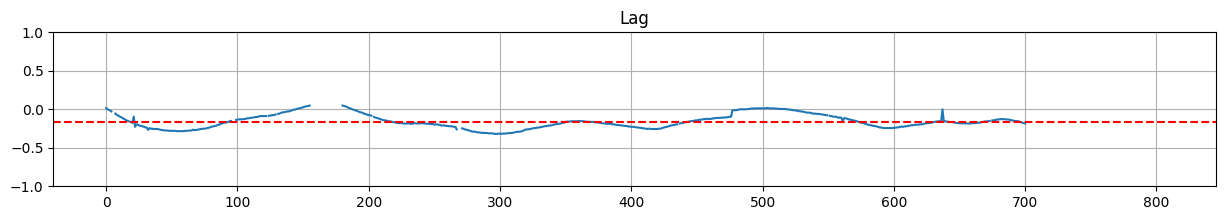

In [59]:
plt.figure(figsize=(15, 2))
plt.plot(np.array(cleaned_final_lag_arr) / 250)
# plot the mean_final_lag as a horizontal line
plt.axhline(y=mean_final_lag / 250, color="r", linestyle="--")
plt.title("Lag")
plt.ylim(-1, 1)
plt.grid()

### Remove this final shift

In [60]:
(
    shifted_final_prodigy_arr,
    shifted_final_prodigy_base_df,
    shifted_final_idun_arr,
    shifted_final_idun_base_arr,
) = adjust_data_by_mean_lag(
    mean_final_lag,
    prodigy_data_pruned,
    prodigy_base_pruned_df,
    idun_data_pruned,
    idun_base_pruned,
)

In [61]:
shifted_final_prodigy_epochs = epoch_data(
    shifted_final_prodigy_arr, config.SECOND_LAG_EPOCH_SIZE
)
shifted_final_idun_epochs = epoch_data(
    shifted_final_idun_arr, config.SECOND_LAG_EPOCH_SIZE
)
(
    shifted_final_correlation_arr,
    shifted_final_max_corr_arr,
    shifted_final_lag_arr,
) = calculate_epochs_lag(shifted_final_prodigy_epochs, shifted_final_idun_epochs)

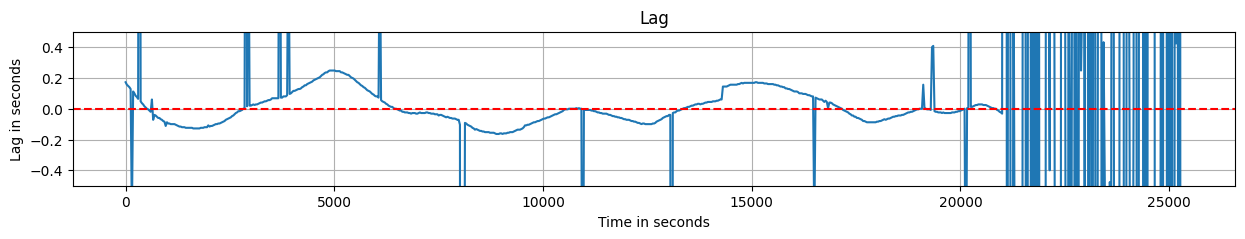

In [63]:
plt.figure(figsize=(15, 2))
# create time array kby muliplying the length of the array by the epoch size
time_seconds = (
    np.arange(len(shifted_final_lag_arr))
    * config.SECOND_LAG_EPOCH_SIZE
    / config.BASE_SAMPLE_RATE
)
plt.plot(time_seconds, np.array(shifted_final_lag_arr) / 250)
plt.axhline(y=0, color="r", linestyle="--")
plt.title("Lag")
plt.xlabel("Time in seconds")
plt.ylabel("Lag in seconds")
plt.ylim(-0.5, 0.5)
plt.grid()
# save image of lag
plt.savefig(os.path.join(folder, subject, night, f"{subject}_{night}_lag.png"))

### Plot final filtered data

/Users/waddaben/.local/share/virtualenvs/idn-sync-data-pWEap7XJ/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/waddaben/.local/share/virtualenvs/idn-sync-data-pWEap7XJ/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


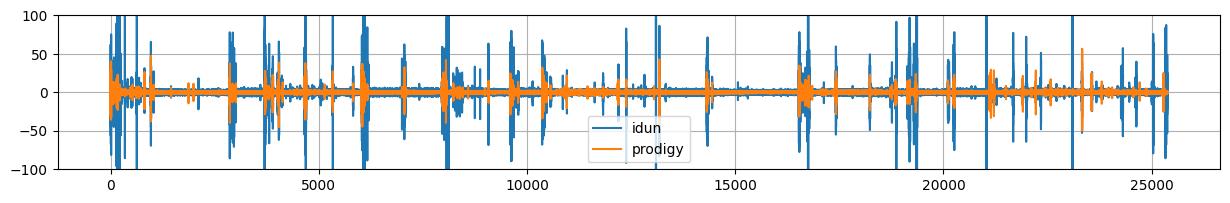

In [64]:
plt.figure(figsize=(15, 2))
# create a seconds axis
time_seconds = np.arange(len(shifted_final_idun_arr)) / config.BASE_SAMPLE_RATE
plt.plot(time_seconds, shifted_final_idun_arr, label="idun")
plt.plot(time_seconds, 0.5 * shifted_final_prodigy_arr, label="prodigy")
plt.legend()
plt.ylim(-100, 100)
plt.grid()

### Final validation, plot final raw data

(6344081, 8)
(6344081,)


/var/folders/z6/9xfx7slx70vby8pq0t9tcmk00000gn/T/ipykernel_9275/4202626747.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(os.path.join(folder, subject, night, f"{subject}_{night}_raw.png"))
/var/folders/z6/9xfx7slx70vby8pq0t9tcmk00000gn/T/ipykernel_9275/4202626747.py:47: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(os.path.join(folder, subject, night, f"{subject}_{night}_filtered.png"))


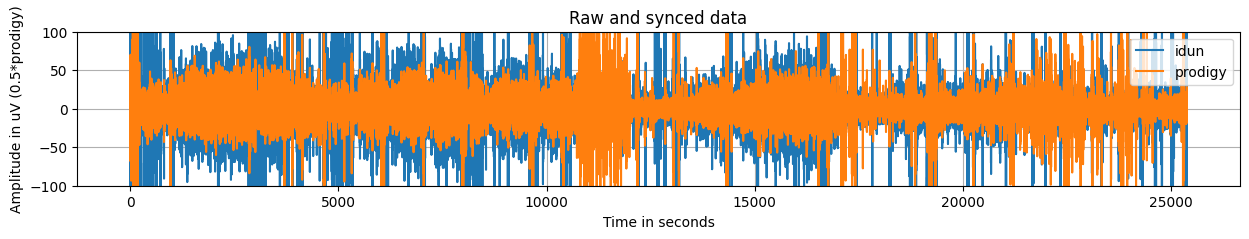

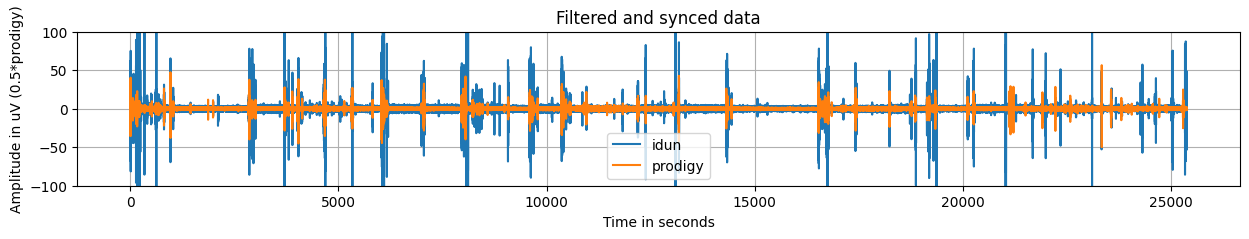

In [65]:
print(shifted_final_prodigy_base_df.shape)
print(shifted_final_idun_base_arr.shape)

prodigy_channel_1_data = np.array(shifted_final_prodigy_base_df[config.CHANNEL_1])
prodigy_channel_2_data = np.array(shifted_final_prodigy_base_df[config.CHANNEL_2])
# minus right eye from left eye
prodigy_channel_1_minus_2 = prodigy_channel_1_data - prodigy_channel_2_data
prodigy_channel_1_minus_2 = (
    prodigy_channel_1_minus_2 * 1000000
)  # To get the data to same scale as ours, v to uv

prodigy_filtered = do_bandpass(
    prodigy_channel_1_minus_2,
    [config.FILTER_RANGE[0], config.FILTER_RANGE[1]],
    config.BASE_SAMPLE_RATE,
)

idun_filtered = do_bandpass(
    shifted_final_idun_base_arr,
    [config.FILTER_RANGE[0], config.FILTER_RANGE[1]],
    config.BASE_SAMPLE_RATE,
)


plt.figure(figsize=(15, 2))
time_seconds = np.arange(len(shifted_final_idun_base_arr)) / config.BASE_SAMPLE_RATE
plt.plot(time_seconds, shifted_final_idun_base_arr, label="idun")
plt.plot(time_seconds, 0.5 * prodigy_channel_1_minus_2, label="prodigy")
plt.legend()
plt.ylim(-100, 100)
plt.title("Raw and synced data")
plt.xlabel("Time in seconds")
plt.ylabel("Amplitude in uV (0.5*prodigy)")
plt.savefig(os.path.join(folder, subject, night, f"{subject}_{night}_raw.png"))
plt.grid()


plt.figure(figsize=(15, 2))
time_seconds = np.arange(len(idun_filtered)) / config.BASE_SAMPLE_RATE
plt.plot(time_seconds, idun_filtered, label="idun")
plt.plot(time_seconds, 0.5 * prodigy_filtered, label="prodigy")
plt.legend()
plt.ylim(-100, 100)
plt.title("Filtered and synced data")
plt.xlabel("Time in seconds")
plt.ylabel("Amplitude in uV (0.5*prodigy)")
plt.savefig(os.path.join(folder, subject, night, f"{subject}_{night}_filtered.png"))
plt.grid()

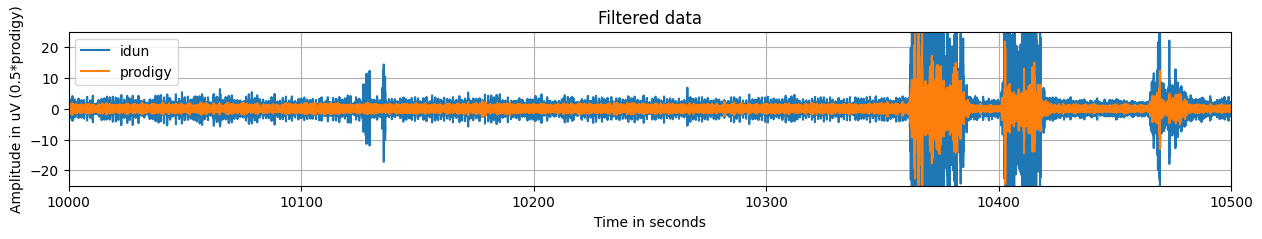

In [66]:
plt.figure(figsize=(15, 2))
time_seconds = np.arange(len(idun_filtered)) / config.BASE_SAMPLE_RATE
plt.plot(time_seconds, idun_filtered, label="idun")
plt.plot(time_seconds, 0.5 * prodigy_filtered, label="prodigy")
plt.legend()
plt.xlim(10000, 10500)
plt.ylim(-25, 25)
plt.title("Filtered data")
plt.xlabel("Time in seconds")
plt.ylabel("Amplitude in uV (0.5*prodigy)")
plt.grid()
plt.savefig(
    os.path.join(folder, subject, night, f"{subject}_{night}_filtered_zoom.png")
)

### Combine Dataframes

In [101]:
# create a time array based on config.BASE_SAMPLE_RATE and length of prodigy_filtered
time_array = np.linspace(
    0,
    len(shifted_final_idun_base_arr) / config.BASE_SAMPLE_RATE,
    len(shifted_final_idun_base_arr),
)
# copy the shifted_final_prodigy_base_df
synced_base_df_copy = copy.deepcopy(shifted_final_prodigy_base_df)
# add shifted_final_idun_base_arr as "IDUN" column to prodigy_base_df_copy
synced_base_df_copy["IDUN"] = shifted_final_idun_base_arr
# make index of prodigy_base_df_copy as time_array
synced_base_df_copy.index = time_array

# save the dataframe as csv, and add a header indicating the sampling rate
save_path = os.path.join(folder, subject, night, f"{subject}_{night}_synced_data.csv")
synced_base_df_copy.to_csv(save_path, index=True)